# PINN - Lotka-Volterra equation

The Lotka-Volterre equations are equations describing the dynamics between predators and prey. The equations describing these dynamics are given as:

$$
\dot{x} = α x - β xy \\
\dot{y} = δxy - γy
$$

In the above equations $x$ are the number of prey and $y$ are the number of predators. The parameters in the equations descirbes:

\- $\boldsymbol{\alpha}$: The reproduction of the preys.

\- $\boldsymbol{\beta}$: How many preys that are killed encountering predators.

\- $\boldsymbol{\delta}$: How many preys the predators manages to kill. Thus also describing how many predators that can live given a number of preys. 

\- $\boldsymbol{\gamma}$: How many predators that will die. Proportional to the number of predators due to more predators resulting in less food.

In this notebook I will try to solve a Lotka-Volterra population model first using an ordinary differential equation solver, then using a PINN. After that we will try to do parameter estimation based on the ODE solution using a PINN.

First we set up the parameter values and initial conditions for the equation:

In [1]:
# Define the time domain:
T = 25
num_samples = 1022
num_boundary = 8

# Defining parameters:
alpha = 2/3
beta = 4/3
delta = 1
gamma = 1

# Set initial values:
x0 = 1
y0 = 2

## Solve using ODE solver:

In [2]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Defining the equations:
def derivatives(t, r):
    x, y = r

    # Equations:
    dy_t = (alpha * x - beta * x * y)
    dx_t = (gamma * x * y - delta * y)

    return dy_t, dx_t

In [4]:
# Create time vector:
t = np.linspace(0, T, num_samples)

# Set initial conditions:
ic = x0, y0

In [5]:
# Solve the equation:
sol = integrate.solve_ivp(derivatives, (0, T), ic, t_eval=t)

# Extract solution:
x_true, y_true = sol.y
x_true = x_true.reshape(-1, 1)
y_true = y_true.reshape(-1, 1)

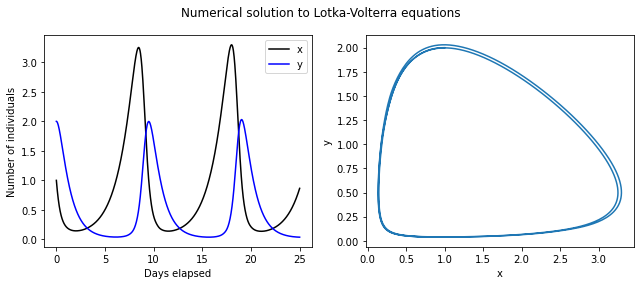

In [6]:
# Plot solution:
fig = plt.figure(figsize= (9, 4))
fig.suptitle("Numerical solution to Lotka-Volterra equations")

plt.subplot(121)
plt.plot(t, x_true, color="black")
plt.plot(t, y_true, color="blue")
plt.legend(["x", "y"])
plt.xlabel("Days elapsed")
plt.ylabel("Number of individuals")

plt.subplot(122)
plt.plot(x_true, y_true)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("figures/NumericalLotkaVolterra", dpi= 300)

## Solve using PINN:

In [7]:
import deepxde as dde

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [8]:
# Define the ODE-system:
def ode_system(input, output):

    # Get the outputs:
    x = output[:, 0:1]
    y = output[:, 1:2]

    # Get the derivatives:
    dx_t = dde.grad.jacobian(output, input, i=0)
    dy_t = dde.grad.jacobian(output, input, i=1)

    # Return the equations:
    return [
        dx_t - alpha * x + beta * x * y,
        dy_t - gamma * x * y + delta * y,
    ]

In [9]:
# Define the time domain of the ODE:
geom = dde.geometry.TimeDomain(0.0, T)

# Function for determening if x on boundary or not:
def boundary(_, on_initial):
    return on_initial

# Set the intial values:
ic1 = dde.IC(geom, lambda X: x0, boundary, component=0)
ic2 = dde.IC(geom, lambda X: y0, boundary, component=1)

In [72]:
# Create the equation:
data = dde.data.PDE(geom, ode_system, [ic1, ic2], num_samples, num_boundary, num_test=300)

In [127]:
# Define and create the neural network:
layer_size = [1] + [32] * 4 + [2]
activation = "tanh"
initializer = "Glorot normal"
net = dde.maps.FNN(layer_size, activation, initializer)

In [131]:
# Combine the data and network into a model:
model = dde.Model(data, net)

In [134]:
# Training:
model.compile("adam", lr=0.00001, loss_weights= [10, 10, 1, 1])
losshistory, train_state = model.train(epochs=4000, display_every= 1000)

#model.compile("L-BFGS")
#losshistory, train_state = model.train()

Compiling model...
'compile' took 0.876285 s



2021-12-02 14:35:27.349190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-02 14:35:29.865914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training model...



2021-12-02 14:35:30.187489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Step      Train loss                                  Test loss                                   Test metric
4171      [3.48e-03, 5.91e-05, 4.60e-12, 1.62e-07]    [3.52e-03, 5.95e-05, 4.60e-12, 1.62e-07]    []  


2021-12-02 14:35:30.909538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5000      [3.46e-03, 5.75e-05, 5.63e-10, 1.60e-05]    [3.49e-03, 5.79e-05, 5.63e-10, 1.60e-05]    []  
6000      [3.45e-03, 5.62e-05, 3.11e-10, 1.61e-05]    [3.49e-03, 5.65e-05, 3.11e-10, 1.61e-05]    []  
7000      [3.45e-03, 5.52e-05, 1.38e-10, 1.61e-05]    [3.48e-03, 5.55e-05, 1.38e-10, 1.61e-05]    []  
8000      [3.45e-03, 5.48e-05, 2.59e-10, 1.61e-05]    [3.48e-03, 5.50e-05, 2.59e-10, 1.61e-05]    []  
8171      [3.45e-03, 5.37e-05, 8.29e-10, 1.58e-05]    [3.48e-03, 5.40e-05, 8.29e-10, 1.58e-05]    []  

Best model at step 4171:
  train loss: 3.55e-04
  test loss: 3.58e-04
  test metric: []

'train' took 78.114345 s



In [ ]:
model.compile("L-BFGS")
losshistory, train_state = model.train()

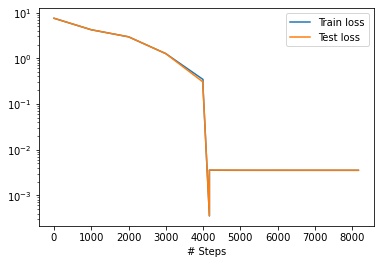

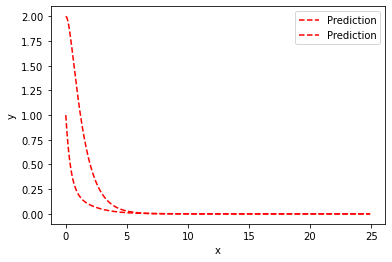

In [135]:
# Plot and save:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

2021-12-02 14:22:13.501884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


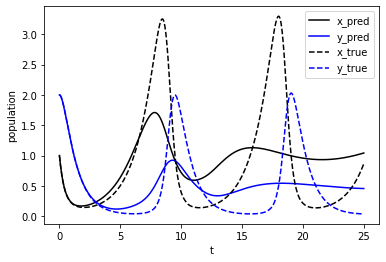

L2 relative error for x: 0.5881410000735577
L2 relative error for y: 0.5746278540615234


In [112]:
# Plot the two solutions in the same plot:
t = t.reshape(num_samples, 1)
sol_pred = model.predict(t)
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

plt.xlabel("t")
plt.ylabel("population")
plt.plot(t, x_pred, color="black", label="x_pred")
plt.plot(t, y_pred, color="blue", label="y_pred")
plt.plot(t, x_true, color="black", label="x_true", linestyle="dashed")
plt.plot(t, y_true, color="blue", label="y_true", linestyle="dashed")
plt.legend()
plt.show()

print("L2 relative error for x:", dde.metrics.l2_relative_error(x_true, x_pred))
print("L2 relative error for y:", dde.metrics.l2_relative_error(y_true, y_pred))

Now we will try to solve the inverse problem, determine the $\alpha$, $\beta$, $\delta$ and $\gamma$ just knowing the form of the equation and data produced by the equation.

In [ ]:
# Defining the variables we want to identify:
alpha = dde.Variable(0.0)
beta = dde.Variable(0.0)
delta = dde.Variable(0.0)
gamma = dde.Variable(0.0)

# Define the time domain of the ODE:
geom = dde.geometry.TimeDomain(0, 10)

# Define the ODE of the system:
def ode_system(x, y):
    x1 = y[:, 0:1]
    x2 = y[:, 1:2]
    dx1_t = dde.grad.jacobian(y, x, i=0)
    dx2_t = dde.grad.jacobian(y, x, i=1)
    return [
        dx1_t - (alpha * x1 - beta * x1 * x2),
        dx2_t - (gamma * x1 * x2 - delta * x2),
    ]

In [ ]:
# Create the boundary function to determine if x is on the boundary or not:
def boundary(_, on_initial):
    return on_initial


# Specify the intial values:
ic1 = dde.IC(geom, lambda X: ic1, boundary, component=0)
ic2 = dde.IC(geom, lambda X: ic2, boundary, component=1)

In [270]:
# Create the time vector for the known data:
t = np.reshape(np.linspace(0, T, num_samples), (num_samples, 1))

# Get the known data from the ODE solver:
x1_true, x2_true = sol.y
x = np.concatenate([x1_true.reshape(len(x1_true), 1), x2_true.reshape(len(x2_true), 1)], axis= 1)

# Define the boundary conditions in the 
observe_x1 = dde.PointSetBC(t, x[:, 0:1], component= 0)
observe_x2 = dde.PointSetBC(t, x[:, 1:2], component= 1)

In [ ]:
# Define the data class:
data = dde.data.PDE(
    geom,
    ode_system,
    [ic1, ic2, observe_x1, observe_x2],
    num_domain= 100,
    num_boundary= 2,
    anchors= t)

/Users/emilhaugstvedt/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "


In [ ]:
# Create neural network:
net = dde.maps.FNN([1] + [40] * 3 + [2], "tanh", "Glorot uniform")

# Combine the data and network into a model:
model = dde.Model(data, net)
model.compile("adam", lr=0.0001, external_trainable_variables=[alpha, beta, delta, gamma])

# Define when to collect the updated values of the variables and save them to a file:
variable = dde.callbacks.VariableValue(
    [alpha, beta, delta, gamma], period=600, filename="variables.dat"
)

# Train the model:
losshistory, train_state = model.train(epochs=20000, callbacks=[variable], display_every= 1000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

NameError: name 'dde' is not defined